In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
db_mon = pd.read_csv('data/mon.csv')
db_med = pd.read_csv('data/med.csv')

In [3]:
choices = db_mon[['sub','choice']].groupby(['sub']).sum()
too_risk_averse = list(choices[choices['choice']<10].index)

db_mon = db_mon[~db_mon['sub'].isin(too_risk_averse)]
too_risk_averse

[11, 14, 16, 40, 50, 65]

In [4]:
choices = db_med[['sub','choice']].groupby(['sub']).sum()
too_risk_averse = list(choices[choices['choice']<10].index)

db_med = db_med[~db_med['sub'].isin(too_risk_averse)]
too_risk_averse

[11, 65]

In [5]:
age = pd.read_excel('/media/Data/Lab_Projects/Aging/aging_session_log.xlsx', sheet_name='sessions').iloc[:,[0,7,9]]
moca = pd.read_excel('/media/Data/Lab_Projects/Aging/aging_session_log.xlsx', sheet_name='assessments').iloc[:,[0,22]]

age.columns.values[0] = "sub"
moca.columns.values[0] = "sub"
age = age[age.gender != 'gender']
age = age.dropna().reset_index()
age = age.drop(['index'], axis=1)

age = age.merge(moca, left_on='sub', right_on='sub')
age['sub'] = age['sub'].map(lambda x: int(x.lstrip('AG_')))
print("number of participants with age and moca scores: ",age.shape[0])

number of participants with age and moca scores:  63


In [6]:
mon_s = list(db_mon['sub'].unique())
med_s = list(db_med['sub'].unique())

db_mon = db_mon[db_mon['sub'].isin(med_s)]
db_med = db_med[db_med['sub'].isin(mon_s)]

print('n =', len(db_med['sub'].unique()))

n = 61


In [7]:
db_mon.head()

,Unnamed: 0,choice,value,risk,ambiguity,sub,catch
84,0,0.0,5,0.25,0.00,10,0.0
85,1,0.0,8,0.25,0.00,10,0.0
86,2,1.0,12,0.50,0.24,10,0.0
87,3,0.0,5,0.50,0.24,10,0.0
88,4,0.0,5,0.25,0.00,10,0.0


In [8]:
age.head()

,sub,gender,age,moca_score
0,10,M,18,28
1,11,F,43,26
2,13,F,48,28
3,14,F,26,30
4,15,F,58,26


In [9]:
db_mon['sub'] = db_mon['sub'].astype('int')
db_med['sub'] = db_med['sub'].astype('int')

db_mon = db_mon.merge(age, left_on='sub', right_on='sub')
db_mon = db_mon[db_mon.moca_score > 25]

db_med = db_med.merge(age, left_on='sub', right_on='sub')
db_med = db_med[db_med.moca_score > 25]

print('Valid subjects: ', len(np.unique(db_mon['sub'])))

Valid subjects:  40


(0.26364698665011066, 0.10021656896421911)


Text(0, 0.5, 'Proportion')

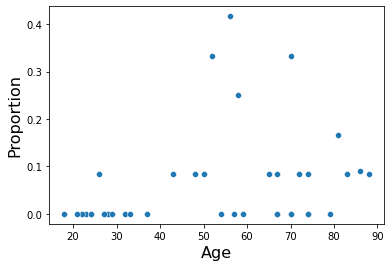

In [10]:
catch = pd.DataFrame(db_mon[db_mon.value==5].groupby('sub').mean()['choice'])
catch = catch.merge(age, left_on='sub', right_on='sub')
print(sp.stats.pearsonr(catch.age, catch.choice))
sns.scatterplot(x = 'age', y = 'choice', data = catch)
plt.xlabel('Age', fontsize=16)
plt.ylabel('Proportion', fontsize=16)

In [11]:
mon_risk = db_mon[db_mon['ambiguity'] == 0][['sub','value','choice']]
mon_amb  = db_mon[db_mon['ambiguity'] >  0][['sub','value','choice']]

med_risk = db_med[db_med['ambiguity'] == 0][['sub','value','choice']]
med_amb  = db_med[db_med['ambiguity'] >  0][['sub','value','choice']]


In [12]:
mon_risk_unc = db_mon[db_mon['ambiguity'] == 0][['sub','risk','choice']]
mon_amb_unc  = db_mon[db_mon['ambiguity'] >  0][['sub','ambiguity','choice']]

med_risk_unc = db_med[db_med['ambiguity'] == 0][['sub','risk','choice']]
med_amb_unc  = db_med[db_med['ambiguity'] >  0][['sub','ambiguity','choice']]

In [13]:
unc_cont_mon = db_mon[(db_mon['ambiguity'] == 0) & (db_mon['risk'] == 0.5)][['sub','value','choice']]
unc_cont_mon = unc_cont_mon.groupby(['sub','value']).mean()
unc_cont_mon.reset_index(inplace=True)

unc_cont_med = db_med[(db_med['ambiguity'] == 0) & (db_med['risk'] == 0.5)][['sub','value','choice']]
unc_cont_med = unc_cont_med.groupby(['sub','value']).mean()
unc_cont_med.reset_index(inplace=True)


In [14]:
mon_prop_r = mon_risk.groupby(['sub','value']).mean()
mon_prop_a = mon_amb.groupby(['sub','value']).mean()
med_prop_r = med_risk.groupby(['sub','value']).mean()
med_prop_a = med_amb.groupby(['sub','value']).mean()

mon_prop_r.reset_index(inplace=True)
mon_prop_a.reset_index(inplace=True)
med_prop_r.reset_index(inplace=True)
med_prop_a.reset_index(inplace=True)

In [15]:
mon_prop_a['choice']=mon_prop_a['choice']-unc_cont_mon['choice']
med_prop_a['choice']=med_prop_a['choice']-unc_cont_med['choice']

In [16]:
mon_prop_unc_r = mon_risk_unc.groupby(['sub','risk']).mean()
mon_prop_unc_a = mon_amb_unc.groupby(['sub','ambiguity']).mean()
med_prop_unc_r = med_risk_unc.groupby(['sub','risk']).mean()
med_prop_unc_a = med_amb_unc.groupby(['sub','ambiguity']).mean()

mon_prop_unc_r.reset_index(inplace=True)
mon_prop_unc_a.reset_index(inplace=True)
med_prop_unc_r.reset_index(inplace=True)
med_prop_unc_a.reset_index(inplace=True)

In [17]:
mon_cont = mon_prop_unc_r[mon_prop_unc_r['risk']==0.5][['sub','choice']]
mon_prop_unc_a = pd.merge(mon_prop_unc_a, mon_cont, on='sub')
mon_prop_unc_a['choice'] = mon_prop_unc_a.choice_x-mon_prop_unc_a.choice_y

med_cont = med_prop_unc_r[med_prop_unc_r['risk']==0.5][['sub','choice']]
med_prop_unc_a = pd.merge(med_prop_unc_a, med_cont, on='sub')
med_prop_unc_a['choice'] = med_prop_unc_a.choice_x-med_prop_unc_a.choice_y

In [18]:
mon_prop_r = mon_prop_r.merge(age, left_on='sub', right_on='sub')
mon_prop_a = mon_prop_a.merge(age, left_on='sub', right_on='sub')
med_prop_r = med_prop_r.merge(age, left_on='sub', right_on='sub')
med_prop_a = med_prop_a.merge(age, left_on='sub', right_on='sub')

In [19]:
mon_prop_unc_r = mon_prop_unc_r.merge(age, left_on='sub', right_on='sub')
mon_prop_unc_a = mon_prop_unc_a.merge(age, left_on='sub', right_on='sub')
med_prop_unc_r = med_prop_unc_r.merge(age, left_on='sub', right_on='sub')
med_prop_unc_a = med_prop_unc_a.merge(age, left_on='sub', right_on='sub')

In [20]:
norm = matplotlib.colors.Normalize(vmin=mon_prop_r["age"].min(), vmax=mon_prop_r["age"].max())
colors = {}
cmap = sns.diverging_palette(240, 10, as_cmap=True )

for cval in mon_prop_r["age"]:
    colors.update({cval : cmap(norm(cval))})
    

/home/nachshon/anaconda3/envs/reversal/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/nachshon/anaconda3/envs/reversal/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/nachshon/anaconda3/envs/reversal/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 7.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/nachshon/anaconda3/envs/reversal/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 17.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


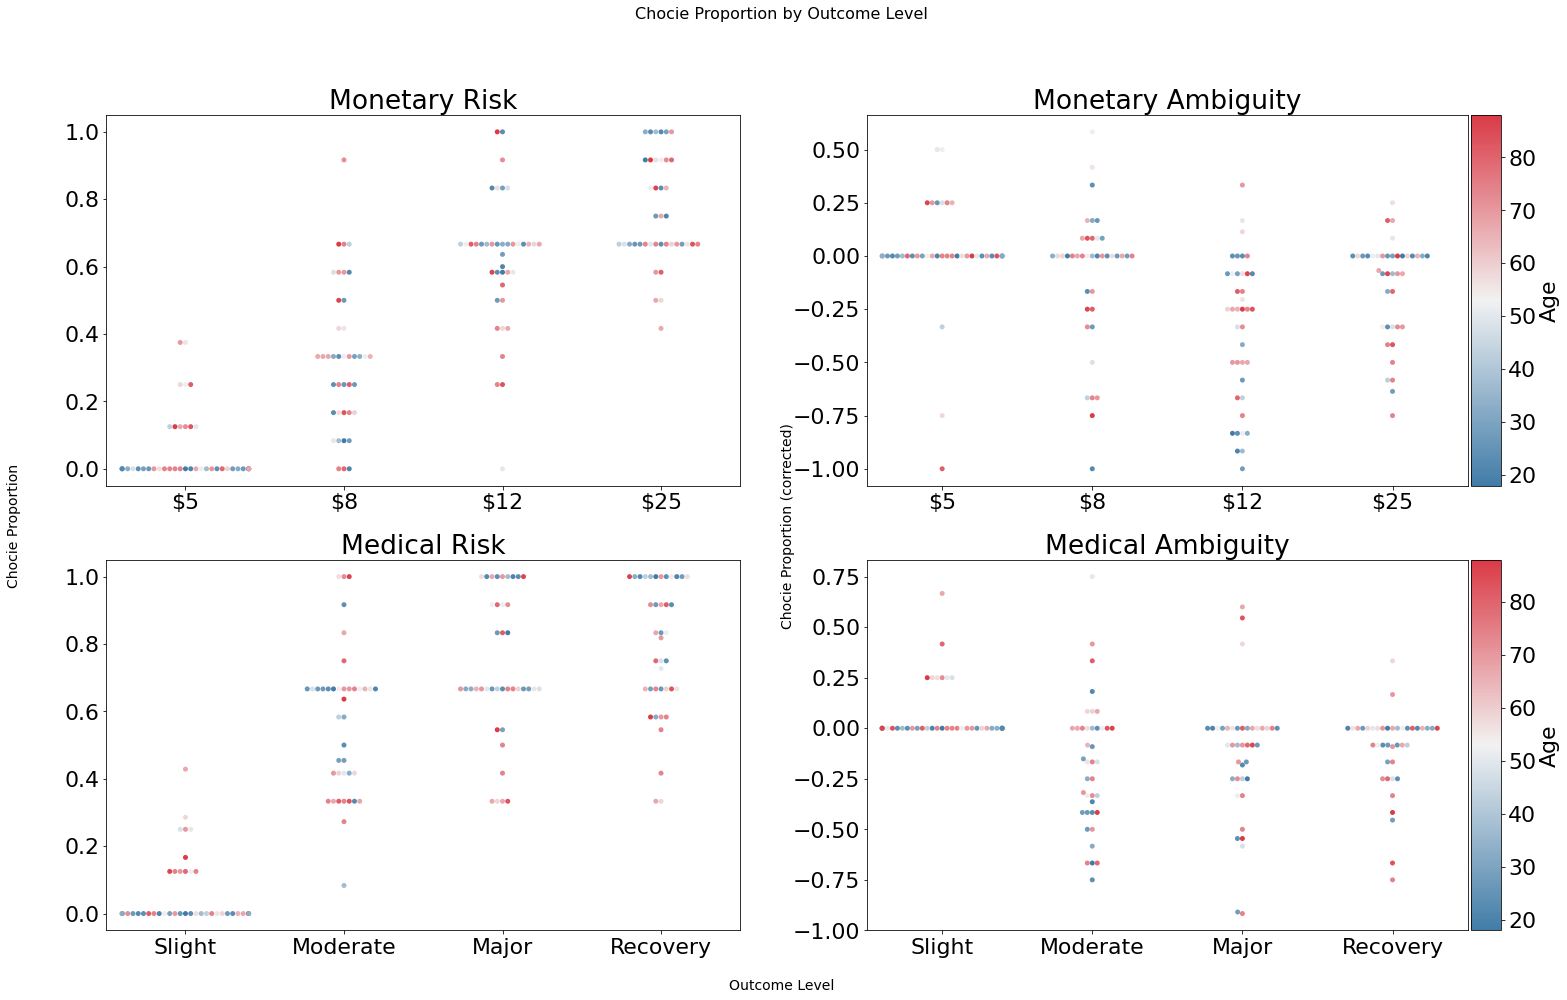

In [26]:
plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize = (25,15))
fig.suptitle('Chocie Proportion by Outcome Level', fontsize=16)

fig.text(0.5, 0.07, 'Outcome Level', ha='center', fontsize=14)
fig.text(0.07, 0.5, 'Chocie Proportion', va='center', rotation='vertical', fontsize=14)
fig.text(0.5, 0.5, 'Chocie Proportion (corrected)', va='center', rotation='vertical', fontsize=14)

ax1 = fig.add_subplot(221)  
ax2 = fig.add_subplot(222) 

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(ax_cb)
cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Age')

ax3 = fig.add_subplot(223)  
ax4 = fig.add_subplot(224)  

sns.swarmplot(x = 'value', y = 'choice', data = mon_prop_r , ax = ax1, hue = 'age', palette = colors)
sns.swarmplot(x = 'value', y = 'choice', data = mon_prop_a , ax = ax2, hue = 'age', palette = colors)
sns.swarmplot(x = 'value', y = 'choice', data = med_prop_r , ax = ax3, hue = 'age', palette = colors)
sns.swarmplot(x = 'value', y = 'choice', data = med_prop_a , ax = ax4, hue = 'age', palette = colors)

ax1.set(xlabel=None, ylabel=None, xticklabels=['$5','$8','$12','$25'], title='Monetary Risk')
ax2.set(xlabel=None, ylabel=None, xticklabels=['$5','$8','$12','$25'], title='Monetary Ambiguity')
ax3.set(xlabel=None, ylabel=None, xticklabels=['Slight','Moderate','Major','Recovery'], title='Medical Risk')
ax4.set(xlabel=None, ylabel=None, xticklabels=['Slight','Moderate','Major','Recovery'], title='Medical Ambiguity')

ax1.legend_.remove()
ax2.legend_.remove()
ax3.legend_.remove()
ax4.legend_.remove()
    
## create colorbar ##
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(ax_cb)
cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Age')
plt.show()

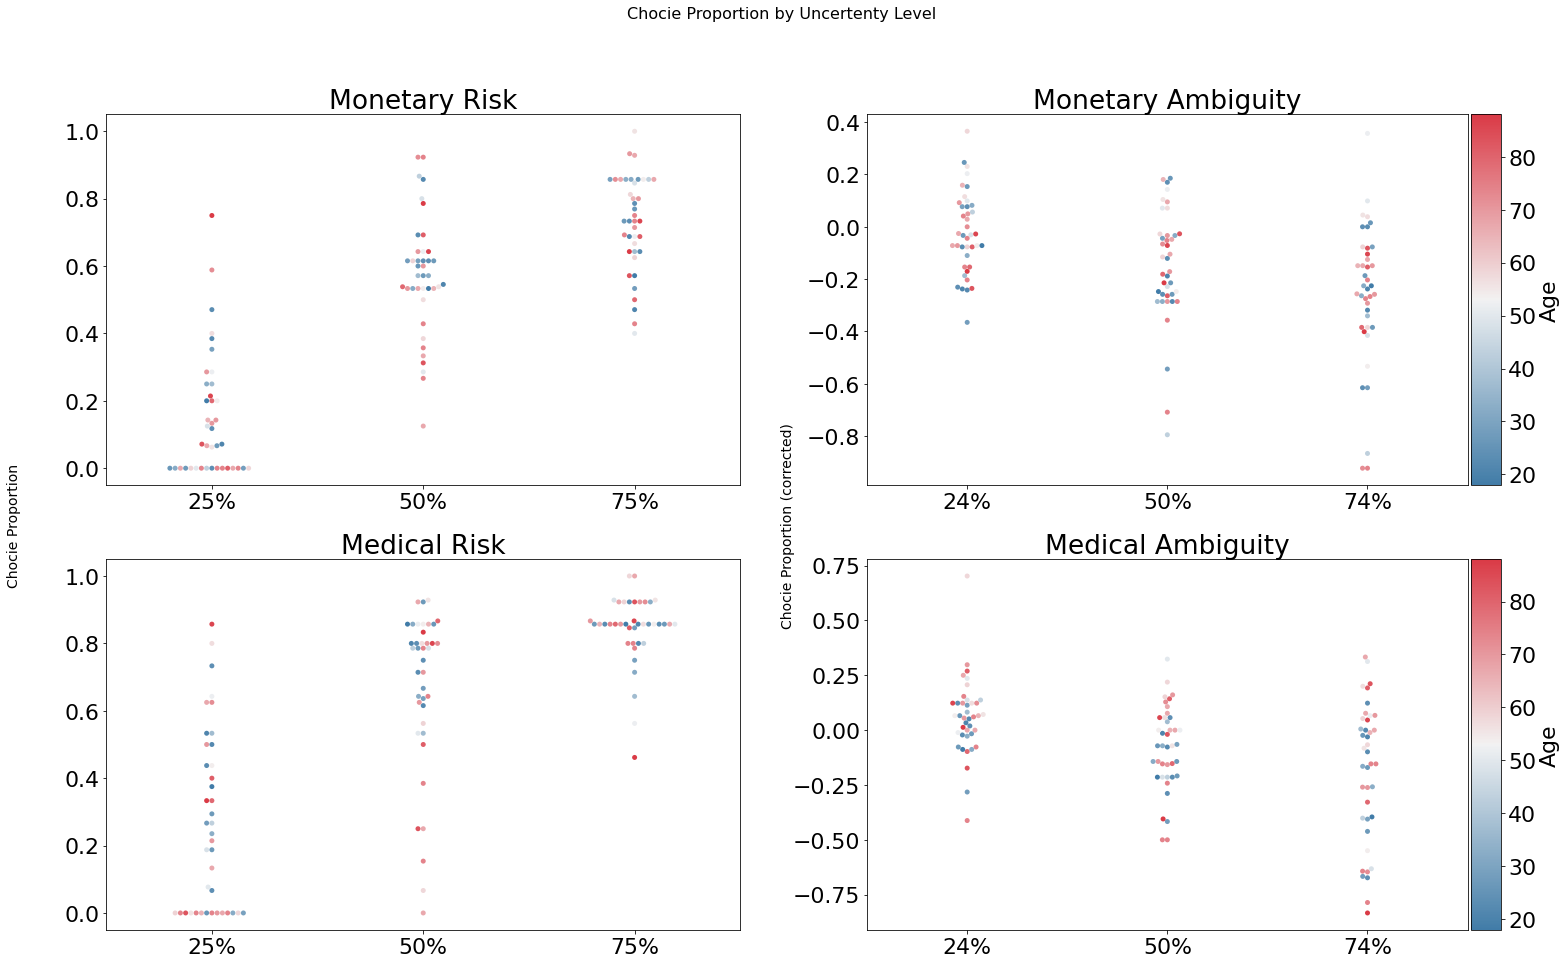

In [27]:
fig = plt.figure(figsize = (25,15))
fig.suptitle('Chocie Proportion by Uncertenty Level', fontsize=16)

#fig.text(0.5, 0.07, 'Outcome Level', ha='center', fontsize=14)
fig.text(0.07, 0.5, 'Chocie Proportion', va='center', rotation='vertical', fontsize=14)
fig.text(0.5, 0.5, 'Chocie Proportion (corrected)', va='center', rotation='vertical', fontsize=14)


ax1 = fig.add_subplot(221)  
ax2 = fig.add_subplot(222)  

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(ax_cb)
cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Age')

ax3 = fig.add_subplot(223)  
ax4 = fig.add_subplot(224)  

sns.swarmplot(x = 'risk', y = 'choice', data = mon_prop_unc_r , ax = ax1, hue = 'age', palette = colors)
sns.swarmplot(x = 'ambiguity', y = 'choice', data = mon_prop_unc_a , ax = ax2, hue = 'age', palette = colors)
sns.swarmplot(x = 'risk', y = 'choice', data = med_prop_unc_r , ax = ax3, hue = 'age', palette = colors)
sns.swarmplot(x = 'ambiguity', y = 'choice', data = med_prop_unc_a , ax = ax4, hue = 'age', palette = colors)

ax1.set(xlabel=None, ylabel=None, xticklabels=['25%','50%','75%'], title='Monetary Risk')
ax2.set(xlabel=None, ylabel=None, xticklabels=['24%','50%','74%'], title='Monetary Ambiguity')
ax3.set(xlabel=None, ylabel=None, xticklabels=['25%','50%','75%'], title='Medical Risk')
ax4.set(xlabel=None, ylabel=None, xticklabels=['24%','50%','74%'], title='Medical Ambiguity')

ax1.legend_.remove()
ax2.legend_.remove()
ax3.legend_.remove()
ax4.legend_.remove()
    
## create colorbar ##
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(ax_cb)
cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Age')
plt.show()


In [28]:
mon_risk_prop = db_mon[(db_mon.choice == 1) & (db_mon.ambiguity == 0)].groupby('sub').count()['choice']/db_mon[(db_mon.ambiguity == 0)].groupby('sub').count()['choice']
mon_ambg_prop = db_mon[(db_mon.choice == 1) & (db_mon.ambiguity >  0)].groupby('sub').count()['choice']/db_mon[(db_mon.ambiguity >  0)].groupby('sub').count()['choice']

med_risk_prop = db_med[(db_med.choice == 1) & (db_med.ambiguity == 0)].groupby('sub').count()['choice']/db_med[(db_med.ambiguity == 0)].groupby('sub').count()['choice']
med_ambg_prop = db_med[(db_med.choice == 1) & (db_med.ambiguity >  0)].groupby('sub').count()['choice']/db_med[(db_med.ambiguity >  0)].groupby('sub').count()['choice']

In [29]:
mon_ambg_prop=mon_ambg_prop-list(mon_cont['choice'])
med_ambg_prop=med_ambg_prop-list(med_cont['choice'])

In [30]:
prop = pd.DataFrame({'mon_risk' : mon_risk_prop,
                     'mon_ambg' : mon_ambg_prop,
                     'med_risk' : med_risk_prop,
                     'med_ambg' : med_ambg_prop})
prop = prop.fillna(0)

In [31]:
prop = prop.merge(age, left_on='sub', right_on='sub')
prop.head()

,sub,mon_risk,mon_ambg,med_risk,med_ambg,gender,age,moca_score
0,10,0.431818,-0.183333,0.681818,-0.232143,M,18,28
1,13,0.568182,-0.225000,0.613636,-0.235714,F,48,28
2,15,0.409091,-0.025641,0.348837,0.283333,F,58,26
3,18,0.318182,-0.112500,0.363636,0.006410,F,83,28
4,19,0.454545,-0.058333,0.500000,-0.132143,M,32,28


In [32]:
corRisk = sp.stats.pearsonr(prop.mon_risk, prop.med_risk)
corAmb = sp.stats.pearsonr(prop.mon_ambg, prop.med_ambg)
corMon = sp.stats.pearsonr(prop.mon_risk, prop.mon_ambg)
corMed = sp.stats.pearsonr(prop.med_risk, prop.med_ambg)

print('corRisk: ', corRisk, 'corAmb ', corAmb, 'corMon ', corMon, 'corMed ', corMed)

corRisk:  (0.3858936528960726, 0.013920524236053548) corAmb  (0.6005025114151985, 4.195274167235429e-05) corMon  (-0.1775537954951488, 0.2730448582532276) corMed  (-0.04670544468317941, 0.7747398857228597)


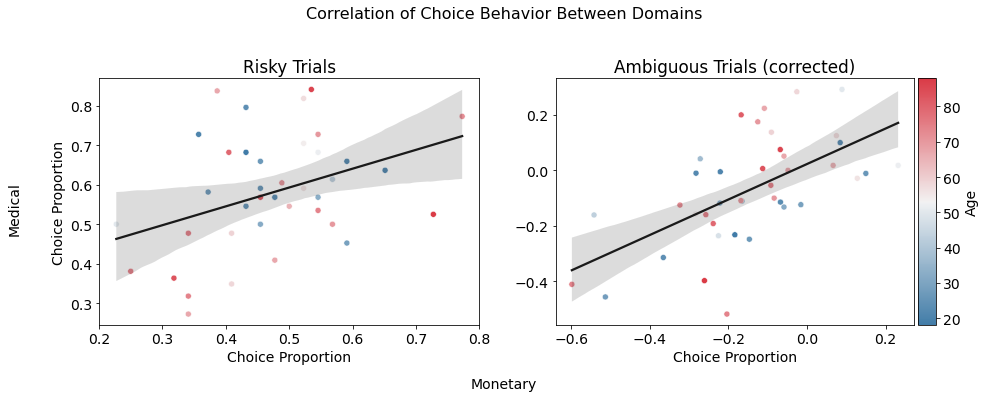

In [38]:
plt.rcParams.update({'font.size': 14})

fig = plt.figure(figsize = (15,10))
fig.suptitle('Correlation of Choice Behavior Between Domains', fontsize=16)

fig.text(0.5, 0.45, 'Monetary', ha='center', fontsize=14)
fig.text(0.04, 0.7, 'Medical', va='center', rotation='vertical', fontsize=14)

ax1 = fig.add_subplot(221)  
ax2 = fig.add_subplot(222)    

sns.scatterplot(x='mon_risk',y='med_risk',data=prop, ax=ax1, hue = 'age', palette = colors)
sns.scatterplot(x='mon_ambg',y='med_ambg',data=prop, ax=ax2, hue = 'age', palette = colors)

sns.regplot(x='mon_risk',y='med_risk',data=prop, ax=ax1, scatter=False, color=".1")
sns.regplot(x='mon_ambg',y='med_ambg',data=prop, ax=ax2, scatter=False, color=".1")


ax1.set(xlabel='Choice Proportion', ylabel='Choice Proportion', title='Risky Trials')
ax2.set(xlabel='Choice Proportion', ylabel=None, title='Ambiguous Trials (corrected)')

ax1.legend_.remove()
ax2.legend_.remove()

## create colorbar ##
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(ax_cb)
cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Age')
plt.show()


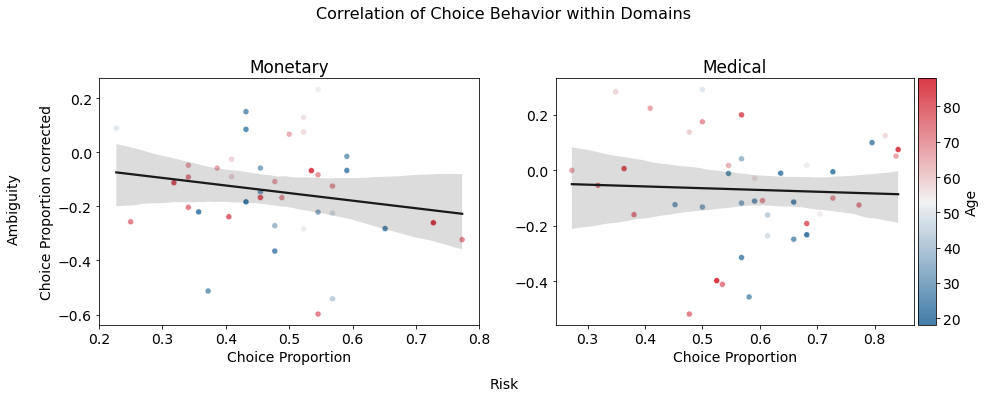

In [39]:
fig = plt.figure(figsize = (15,10))
fig.suptitle('Correlation of Choice Behavior within Domains', fontsize=16)

fig.text(0.5, 0.45, 'Risk', ha='center', fontsize=14)
fig.text(0.04, 0.7, 'Ambiguity', va='center', rotation='vertical', fontsize=14)

ax1 = fig.add_subplot(221)  
ax2 = fig.add_subplot(222)

sns.scatterplot(x='mon_risk',y='mon_ambg',data=prop, ax=ax1, hue = 'age', palette = colors)
sns.scatterplot(x='med_risk',y='med_ambg',data=prop, ax=ax2, hue = 'age', palette = colors)


sns.regplot(x='mon_risk',y='mon_ambg',data=prop, ax=ax1, scatter=False, color=".1")
sns.regplot(x='med_risk',y='med_ambg',data=prop, ax=ax2, scatter=False, color=".1")


ax1.set(xlabel='Choice Proportion', ylabel='Choice Proportion corrected', title='Monetary')
ax2.set(xlabel='Choice Proportion', ylabel=None, title='Medical')

ax1.legend_.remove()
ax2.legend_.remove()

## create colorbar ##
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(ax_cb)
cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Age')
plt.show()


In [ ]:
db_mon.head()

In [ ]:
choice_age = db_mon[db_mon.value > 5].groupby('sub').sum('choice')
choice_age = choice_age.merge(age, left_on='sub', right_on='sub')
choice_age = choice_age.dropna()
choice_age.head()

In [ ]:
sp.stats.pearsonr(choice_age.Age, choice_age.choice)

In [ ]:
sns.regplot(x = 'Age', y = 'choice', data = choice_age)

In [ ]:
choice_age_med = db_med[db_med.value > 5].groupby('sub').sum('choice')
choice_age_med = choice_age_med.merge(age, left_on='sub', right_on='sub')
choice_age_med = choice_age_med.dropna()
choice_age_med.head()

In [ ]:
sns.regplot(x = 'Age', y = 'choice', data = choice_age_med)

In [ ]:
sp.stats.pearsonr(choice_age_med.Age, choice_age_med.choice)